# Computer vision using Pytorch

### Useful computer vision libraries
* `torchvision` - computer vision for Pytorch
* `torchvision.datasets` - computer vision datasets
* `torchvision.models` - pre-trained models
* `torchvision.transforms` - useful for representing image data in a numeric format
* `opencv` - best for image manipulation and computer vision tasks in general

In [153]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.1 MB/s eta 0:00:00


In [166]:
# Imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

import mlxtend

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm
import pandas as pd
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from timeit import default_timer as timer

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


## Dataset
[Avaliable vision datasets (from torchvision)](https://pytorch.org/vision/main/datasets.html)
* Standard benchmark dataset: [Imagenet](https://www.image-net.org/update-mar-11-2021.php)

In [3]:
training_data = datasets.FashionMNIST(root='data',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.ToTensor(),
                                      target_transform=None # no transformation for labels
                                      )

100%|██████████| 26421880/26421880 [00:02<00:00, 12261781.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207922.34it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3872786.09it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22800714.88it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
testing_data = datasets.FashionMNIST(root='data',
                                      train=False,
                                      download=True,
                                      transform=ToTensor(),
                                      target_transform=None # no transformation for labels
                                      )

In [5]:
len(training_data), len(testing_data)

(60000, 10000)

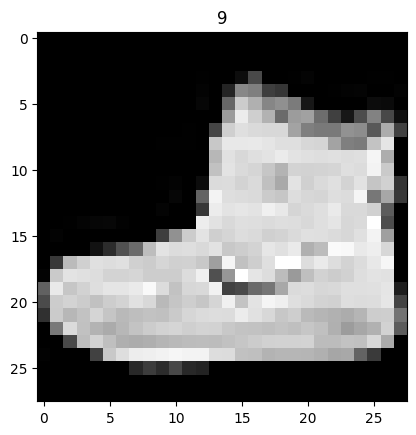

In [6]:
image, label = training_data[0]
# image = image.numpy().transpose(1, 2, 0)
plt.title(label)
plt.imshow(image.squeeze(), cmap="gray")

In [7]:
class_name = training_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
image.shape

torch.Size([1, 28, 28])

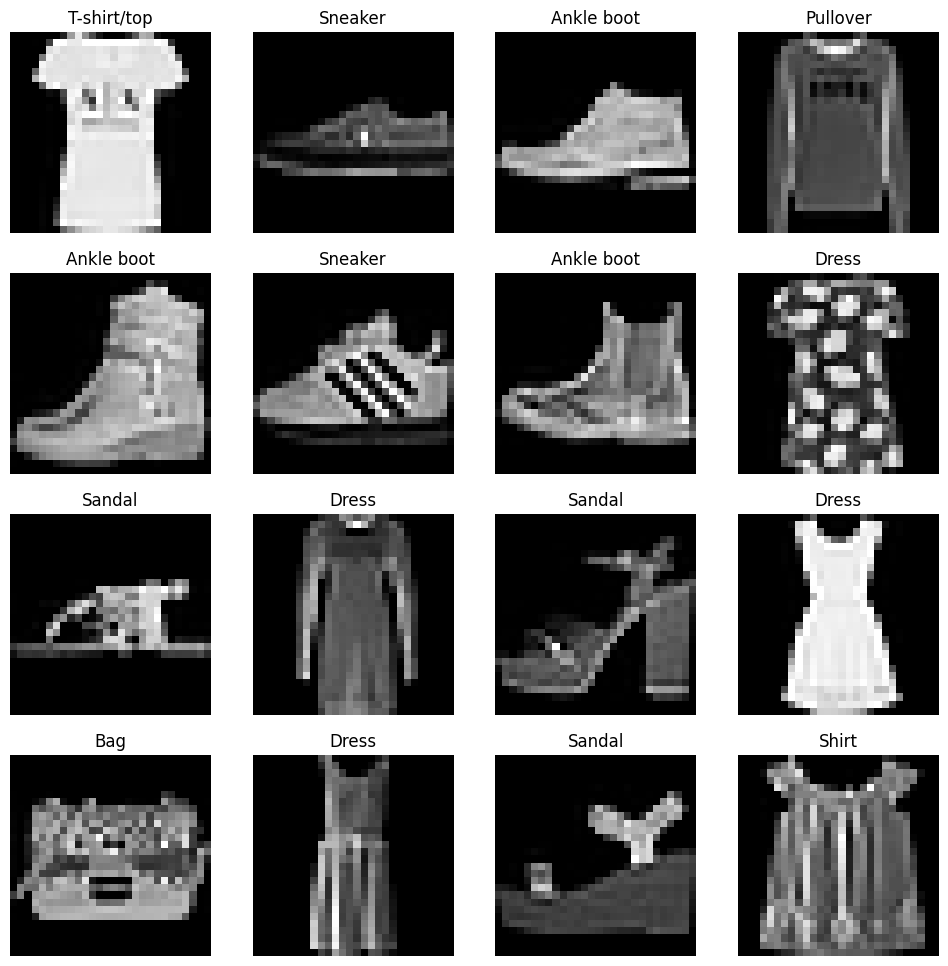

In [9]:
torch.manual_seed(21)
fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for idx in range(1, rows*cols + 1):
    random_image = torch.randint(0, len(training_data), size=[1]).item()
    image, label = training_data[random_image]
    plt.subplot(rows, cols, idx)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_name[label])
    plt.axis(False)

## Prepare the data using a `DataLoader`
* turn the dataset into an iterable
* ! required for large datasets

In [10]:
BATCH_SIZE = 32

In [214]:
train_dataloader = DataLoader(dataset=training_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=testing_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b8c75a4d7e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b8c75a4e7d0>)

In [12]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [13]:
# shape of each batch
train_example_features, train_example_labels = next(iter(train_dataloader))
train_example_features.shape, train_example_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

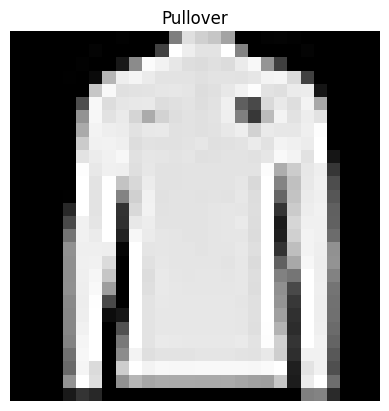

In [14]:
# showcase a random image
rand_idx = torch.randint(0, len(train_example_features), size=[1]).item()
img, label = train_example_features[rand_idx], train_example_labels[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.axis(False)

## Build a baseline model

In [15]:
class FashionMNISTModel(nn.Module):
    def __init__(self, in_shape: int, out_shape:int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
torch.manual_seed(21)

fashion_model = FashionMNISTModel(in_shape=784, out_shape=len(class_name), hidden_units=10).to("cpu")
fashion_model

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=fashion_model.parameters(), lr=0.01)

In [18]:
import requests
from pathlib import Path

# Get some pre-written vis functions
if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import accuracy_fn

## Experiment tracking functions

In [19]:
from timeit import default_timer as timer

def print_time(start, end, device: torch.device = None):
    total_time = end - start
    print(f"Training time on {device} - {total_time: .3f} seconds")
    return total_time

## Training loop setup
* loop through epochs
* loop through training batches
* calculate the loss per batch

In [20]:
epochs = 3
training_start_time = timer()

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        fashion_model.train()

        preds = fashion_model(X)
        loss = loss_function(preds, y)
        # accumulate the loss - avg at the end for num of batches
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        train_acc += accuracy_fn(y, preds.argmax(dim=1))

        optimizer.step()

        if batch % 400 == 0:
            print(f"Batch {batch} | Items {batch * len(X)}/{len(train_dataloader.dataset)}")

    # Get the avg loss per epoch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Testing loop
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for test_X, test_y in test_dataloader:
            test_preds = fashion_model(test_X)
            test_loss += loss_function(test_preds, test_y)
            test_acc += accuracy_fn(test_y, test_preds.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        print(f"Epoch: {epoch} | Loss: {train_loss: .5f} | Acc: {train_acc: .5f} | Test loss: {test_loss: .5f} | Test acc: {test_acc: .5f}")

training_end_time = timer()
print_time(training_start_time, training_end_time, device=str(next(fashion_model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Batch 0 | Items 0/60000
Batch 400 | Items 12800/60000
Batch 800 | Items 25600/60000
Batch 1200 | Items 38400/60000
Batch 1600 | Items 51200/60000
Epoch: 0 | Loss:  0.88976 | Acc:  72.12000 | Test loss:  0.62474 | Test acc:  78.25479
Batch 0 | Items 0/60000
Batch 400 | Items 12800/60000
Batch 800 | Items 25600/60000
Batch 1200 | Items 38400/60000
Batch 1600 | Items 51200/60000
Epoch: 1 | Loss:  0.55695 | Acc:  80.92500 | Test loss:  0.54935 | Test acc:  80.79073
Batch 0 | Items 0/60000
Batch 400 | Items 12800/60000
Batch 800 | Items 25600/60000
Batch 1200 | Items 38400/60000
Batch 1600 | Items 51200/60000
Epoch: 2 | Loss:  0.50391 | Acc:  82.63000 | Test loss:  0.51561 | Test acc:  81.89896
Training time on cpu -  26.623 seconds


26.622526165999986

## Make more predictions and evaluate the model's preformance

In [21]:
torch.manual_seed(21)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               accuracy_fn,
               device: torch.device = "cpu"
               ):
    """ Returns a dict of model results """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            # accumulate loss and acc per batch

            loss += loss_function(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # scale loss and acc for avg per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}


In [22]:
fashion_model_results = eval_model(model=fashion_model,
                                   data_loader=test_dataloader,
                                   loss_function=loss_function,
                                   accuracy_fn=accuracy_fn)
fashion_model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.515182614326477,
 'model_acc': 81.89896166134186}

## Setup device agnostic code

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Build a non-linear model

In [24]:
class NonLinearFashionMNISTModel(nn.Module):
    def __init__(self, in_shape: int, out_shape:int, hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [25]:
fashion_mode_v2 = NonLinearFashionMNISTModel(784, len(class_name), 20).to(device)
fashion_mode_v2, next(fashion_mode_v2.parameters()).device

(NonLinearFashionMNISTModel(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=20, bias=True)
     (2): ReLU()
     (3): Linear(in_features=20, out_features=20, bias=True)
     (4): ReLU()
     (5): Linear(in_features=20, out_features=10, bias=True)
     (6): ReLU()
   )
 ),
 device(type='cuda', index=0))

In [26]:
# set loss function, optimizer and acc function
from helper_functions import accuracy_fn
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=fashion_mode_v2.parameters(), lr=0.01)

### Modular training and testing functions

In [27]:
def train_step(
            model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_function: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device
            ):

    """ Performs a training step for the input model """
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        preds = model(X)
        loss = loss_function(preds, y)
        # accumulate the loss - avg at the end for num of batches
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        train_acc += accuracy_fn(y, preds.argmax(dim=1))

        optimizer.step()

    # Get the avg loss and acc per epoch
    train_loss /= len(data_loader.dataset)
    train_acc /= len(data_loader.dataset)

    print(f"Loss: {train_loss: .5f} | Acc: {train_acc: .5f}")

In [28]:
def test_step(
            model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_function: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device
            ):

    """ Performs a testing step for the input model """
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X_test, y_test in data_loader:
            # Put data on target device
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_preds = model(X_test)
            test_loss += loss_function(test_preds, y_test)
            test_acc += accuracy_fn(y_test, test_preds.argmax(dim=1))

        # Get the avg loss and acc per epoch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        print(f"Test Loss: {test_loss: .5f} | Test Acc: {test_acc: .5f}")

## Training loop using train and test functions

In [29]:
EPOCHS = 3
train_time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------")

    train_step(fashion_mode_v2,
               train_dataloader,
               loss_function,
               accuracy_fn,
               device)

    test_step(fashion_mode_v2,
              test_dataloader,
              loss_function,
              accuracy_fn,
              device)

train_time_end = timer()
total_train_time = print_time(train_time_start, train_time_end, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Loss:  0.04146 | Acc:  1.70984
Test Loss:  0.92183 | Test Acc:  68.51038
Epoch: 1
--------
Loss:  0.02558 | Acc:  2.28896
Test Loss:  0.78205 | Test Acc:  74.69050
Epoch: 2
--------
Loss:  0.02286 | Acc:  2.42198
Test Loss:  0.73420 | Test Acc:  77.85543
Training time on cuda -  32.833 seconds


In [30]:
eval_results = eval_model(fashion_mode_v2,
                          test_dataloader,
                          loss_function,
                          accuracy_fn,
                          device)
eval_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'NonLinearFashionMNISTModel',
 'model_loss': 0.7338365912437439,
 'model_acc': 77.85543130990415}

# Build a CNN
* great CNN resource [website](https://poloclub.github.io/cnn-explainer/)
* Build a *CNN* and compare results with the previous

In [101]:
class ConvolutionalFashonMnist(nn.Module):
    """ Model architecture that replicates TinyVGG """
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # classifier layer
        self.out_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=out_shape)
        )

    def forward(self, x):
         x_out1 = self.conv_block_1(x)
        #  print(x_out1.shape)
         x_out2 = self.conv_block_2(x_out1)
        #  print(x_out2.shape)
         output = self.out_layer(x_out2)
        #  print(output.shape)

         return output

In [102]:
torch.manual_seed(21)
cnn_model = ConvolutionalFashonMnist(1, len(class_name), 10).to(device)
cnn_model

ConvolutionalFashonMnist(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### Stepping through `nn.Conv2d()`

In [86]:
images = torch.randn(size=(32, 1, 28, 28))
test_image = images[0]

test_image.shape

torch.Size([1, 28, 28])

In [39]:
# create a single conv2d layer
test_conv_layer = nn.Conv2d(in_channels=3,
                            out_channels=10,
                            kernel_size=3,
                            stride=1,
                            padding=1)
conv_output = test_conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### Stepping through `nn.MaxPool2d()`

In [51]:
test_max_pool = nn.MaxPool2d(kernel_size=2)
maxpool_output = test_max_pool(test_image)
maxpool_output.shape

torch.Size([3, 32, 32])

### Test model architecture with random data


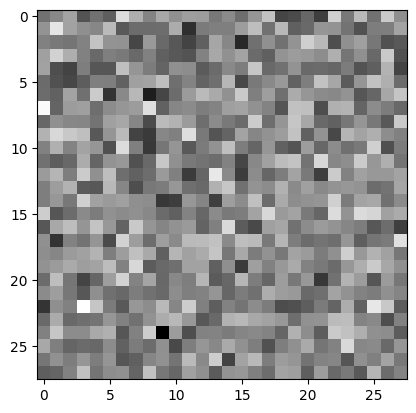

In [87]:
plt.imshow(test_image.squeeze(), cmap="gray")

In [96]:
# pass img through model
pred = cnn_model(test_image.unsqueeze(0).to(device))
print(pred)
print(torch.argmax(pred))
print(class_name[torch.argmax(pred)])

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])
torch.Size([1, 10])
tensor([[ 7.0034e-02,  6.2872e-02,  7.8846e-02,  6.8287e-02,  3.3929e-02,
          4.6037e-02,  2.5250e-02, -3.4427e-02, -5.2525e-05,  1.3856e-02]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2, device='cuda:0')
Pullover


## Training the CNN on the dataset

In [103]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=0.1)

In [178]:
EPOCHS = 3
start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------")

    train_step(model=cnn_model,
               data_loader=train_dataloader,
               loss_function=loss_function,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=cnn_model,
               data_loader=test_dataloader,
               loss_function=loss_function,
               accuracy_fn=accuracy_fn,
               device=device)

print_time(start_time, timer(), device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Loss:  0.00911 | Acc:  2.79766
Test Loss:  0.32589 | Test Acc:  88.51837
Epoch: 1
--------
Loss:  0.00895 | Acc:  2.80026
Test Loss:  0.32037 | Test Acc:  88.81789
Epoch: 2
--------
Loss:  0.00882 | Acc:  2.81021
Test Loss:  0.31851 | Test Acc:  88.99760
Training time on cuda -  36.679 seconds


36.679404854001405

In [107]:
results_cnn = eval_model(cnn_model, test_dataloader, loss_function, accuracy_fn, device)
results_cnn

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ConvolutionalFashonMnist',
 'model_loss': 0.32844218611717224,
 'model_acc': 88.08905750798722}

## Compare results for all models

In [111]:
compare_results = pd.DataFrame([fashion_model_results, eval_results, results_cnn])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModel,0.515183,81.898962
1,NonLinearFashionMNISTModel,0.733837,77.855431
2,ConvolutionalFashonMnist,0.328442,88.089058


Text(0, 0.5, 'model')

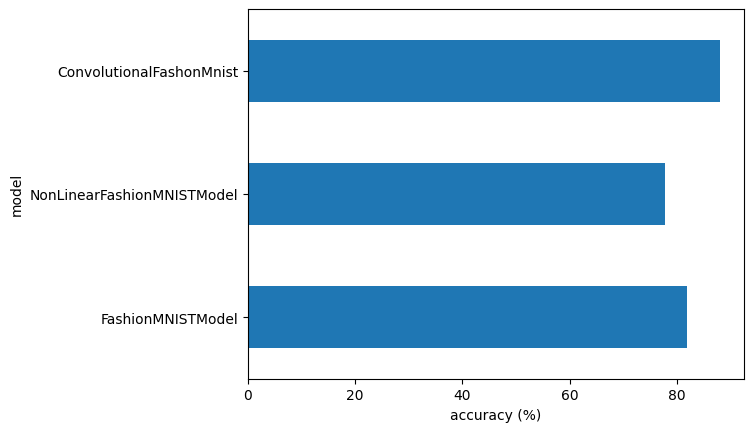

In [114]:
# plot the model performance
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### Evaluate some predictions

In [116]:
def make_predictions(model, data, device):
    pred_probabilities = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logits = model(sample)
            pred = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probabilities.append(pred.cpu())
    # turn into tensor and return probabilities
    return torch.stack(pred_probabilities)

In [118]:
img, label = testing_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [121]:
import random
random.seed(21)
test_samples = []
test_labels = []

for sample, label in random.sample(list(testing_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Ankle boot')

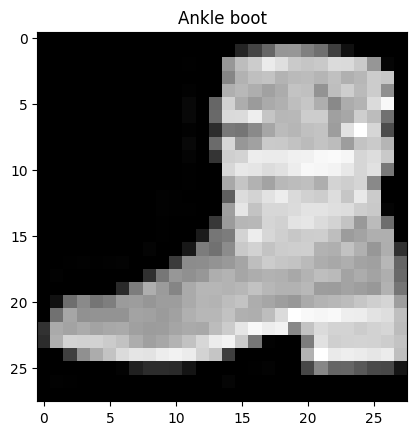

In [123]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_name[test_labels[0]])

### Make predictions

In [125]:
pred_probs = make_predictions(model=cnn_model,
                              data=test_samples,
                              device=device)

pred_probs

tensor([[5.2528e-10, 3.5012e-11, 4.4551e-11, 1.8791e-11, 1.7258e-09, 1.9756e-05,
         6.9402e-07, 9.6629e-07, 1.4913e-07, 9.9998e-01],
        [4.3215e-03, 2.4246e-05, 9.1263e-01, 7.4007e-05, 3.2136e-02, 7.3372e-07,
         5.0789e-02, 5.2539e-08, 2.6328e-05, 2.4890e-08],
        [5.2936e-03, 1.2067e-05, 1.5560e-02, 5.4151e-04, 9.4788e-02, 1.0126e-09,
         8.8094e-01, 1.7935e-09, 2.8639e-03, 1.0491e-08],
        [2.2099e-03, 4.3603e-05, 1.3491e-02, 1.3652e-02, 1.5987e-01, 1.3270e-07,
         8.0374e-01, 1.2486e-07, 6.9944e-03, 1.8348e-07],
        [1.2136e-10, 1.1767e-12, 7.8507e-12, 3.3855e-11, 5.1578e-11, 2.7908e-05,
         3.3076e-09, 6.4606e-06, 9.4667e-08, 9.9997e-01],
        [6.2099e-09, 1.3278e-11, 7.0332e-11, 2.6648e-09, 1.4082e-09, 6.7928e-04,
         2.2493e-09, 9.8987e-01, 2.3181e-06, 9.4512e-03],
        [5.5397e-08, 9.9443e-11, 1.0719e-09, 2.8029e-09, 3.5770e-10, 9.9997e-01,
         7.8937e-08, 3.3149e-06, 3.0032e-05, 9.2126e-07],
        [8.3421e-05, 4.5464

In [129]:
pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels, test_labels

(tensor([9, 2, 6, 6, 9, 7, 5, 4, 3]), [9, 2, 6, 4, 9, 7, 5, 4, 3])

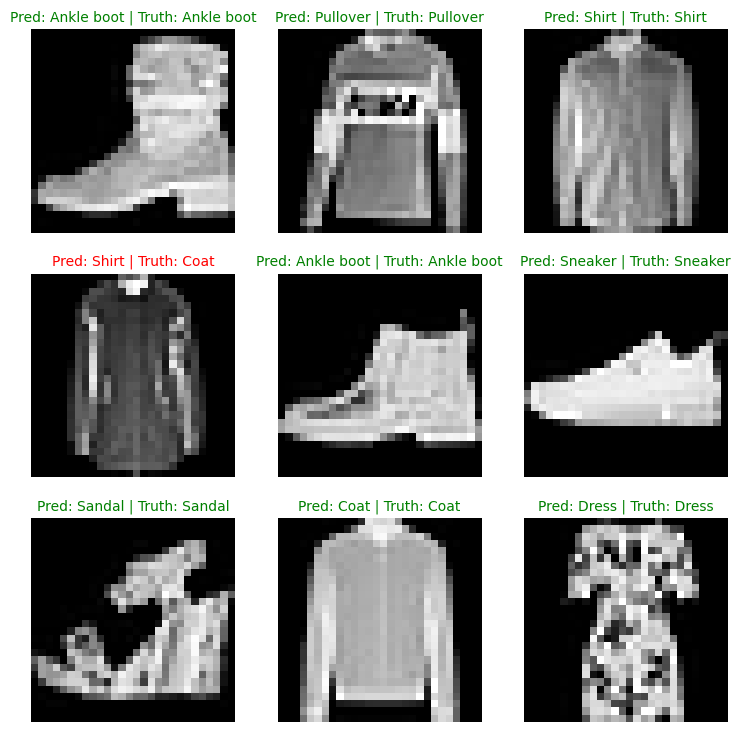

In [130]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = class_name[pred_labels[i]]
    truth_label = class_name[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

## Confusion metrics

In [217]:
y_preds = []
cnn_model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="making preds..."):
        X, y = X.to(device), y.to(device)
        y_logit = cnn_model(X)

        pred_probs = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        # put pred on cpu for evaluation (matplotlib needs them on CPU)
        y_preds.append(pred_probs.cpu())

y_preds_tensor = torch.cat(y_preds)

making preds...:   0%|          | 0/313 [00:00<?, ?it/s]

In [218]:
y_preds_tensor[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [219]:
testing_data.targets[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

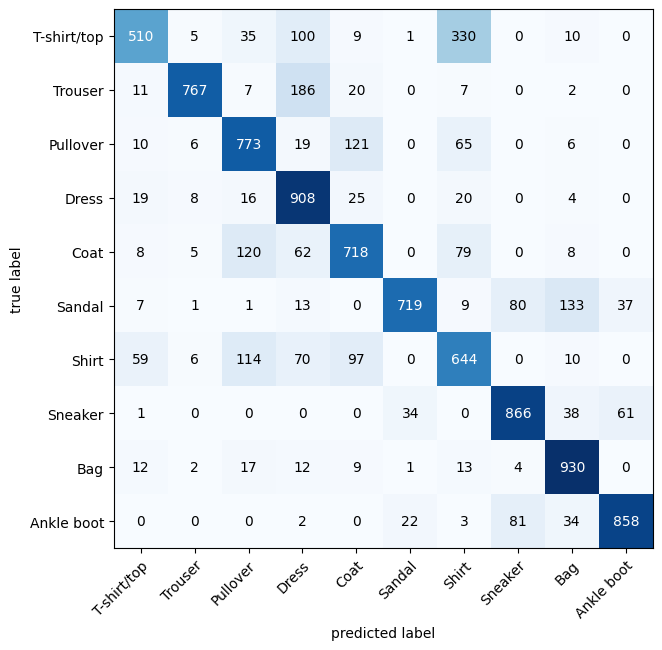

In [223]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_name))
confmat_tensor = confmat(y_preds_tensor, testing_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(10, 7)
)

## Save and load the model

### Save

In [224]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "fashion_MNIST_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH  / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/fashion_MNIST_CNN.pth')

In [226]:
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=cnn_model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/fashion_MNIST_CNN.pth


### Load

In [230]:
load_model_class = ConvolutionalFashonMnist(in_shape=1,
                                            out_shape=10,
                                            hidden_units=10)

load_model_class.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
load_model_class.to(device)

ConvolutionalFashonMnist(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [235]:
# Evaluate the model
torch.manual_seed(21)
loaded_cnn_results = eval_model(model=load_model_class,
                         data_loader=test_dataloader,
                         loss_function=loss_function,
                         accuracy_fn=accuracy_fn,
                         device=device)

cnn_results = eval_model(model=cnn_model,
                         data_loader=test_dataloader,
                         loss_function=loss_function,
                         accuracy_fn=accuracy_fn,
                         device=device)

loaded_cnn_results, cnn_results

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

({'model_name': 'ConvolutionalFashonMnist',
  'model_loss': 0.31771931052207947,
  'model_acc': 89.02755591054313},
 {'model_name': 'ConvolutionalFashonMnist',
  'model_loss': 0.31771931052207947,
  'model_acc': 89.02755591054313})

In [236]:
# check if results are close to each other
torch.isclose(torch.tensor(loaded_cnn_results["model_loss"]),
              torch.tensor(cnn_results["model_loss"]))

tensor(True)